# Skin lesion classification with transfer learning

Most of the code in this notebook was taken from https://github.com/falloutdurham/beginners-pytorch-deep-learning/. Here, it was tweaked to solve the sking lesion classification problem 

Please refer to the following book for more details:
Programming PyTorch for Deep Learning by Ian Pointer - Released September 2019, Publisher(s): O'Reilly Media, Inc., ISBN: 9781492045342

### Imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

folder_path = "/content/drive/My Drive/Skin_Lesions"

## Get data 

### Image transforms

In [0]:
im_size = 256

train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5), # used for data augmentation
    #transforms.RandomVerticalFlip(p=0.5), # used for data augmentation
    transforms.Resize((im_size,im_size)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )                            
])

img_transforms = transforms.Compose([
    transforms.Resize((im_size,im_size)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

## Class balancing sampler

In [0]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

In [0]:
train_data_path = folder_path + "/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transform, is_valid_file=check_image)                                                                        
                                                                                
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=1000, replacement=True)

batch_size = 64

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler)

### Data loaders

In [0]:
test_data_path = folder_path + "/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=img_transforms, is_valid_file=check_image)

val_data_path = folder_path + "/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)

val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

## Load pre-trained model

In [0]:
transfer_model = models.resnet50(pretrained=True)

## Freeze parameters

Freezing everything except batch normalization layers

In [0]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

## Replacing the classifier

In [0]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2))

# Training

### Learning Rate Finder

In [0]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

## Training procedure

In [0]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

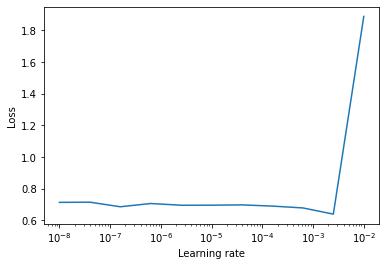

In [12]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [13]:
optimizer = optim.Adam(transfer_model.parameters(), lr=lrs)
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=15, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 2.11, Validation Loss: 0.76, accuracy = 0.47
Epoch: 1, Training Loss: 0.69, Validation Loss: 0.49, accuracy = 0.75
Epoch: 2, Training Loss: 0.46, Validation Loss: 0.40, accuracy = 0.83
Epoch: 3, Training Loss: 0.23, Validation Loss: 0.46, accuracy = 0.82
Epoch: 4, Training Loss: 0.13, Validation Loss: 0.57, accuracy = 0.83
Epoch: 5, Training Loss: 0.04, Validation Loss: 0.68, accuracy = 0.85
Epoch: 6, Training Loss: 0.02, Validation Loss: 0.59, accuracy = 0.85
Epoch: 7, Training Loss: 0.03, Validation Loss: 0.98, accuracy = 0.83
Epoch: 8, Training Loss: 0.01, Validation Loss: 0.65, accuracy = 0.83
Epoch: 9, Training Loss: 0.01, Validation Loss: 0.87, accuracy = 0.83
Epoch: 10, Training Loss: 0.00, Validation Loss: 0.84, accuracy = 0.83
Epoch: 11, Training Loss: 0.00, Validation Loss: 0.94, accuracy = 0.83
Epoch: 12, Training Loss: 0.00, Validation Loss: 0.99, accuracy = 0.83
Epoch: 13, Training Loss: 0.00, Validation Loss: 0.96, accuracy = 0.83
Epoch: 14, Train

## Test

In [14]:
model = transfer_model
num_correct = 0 
num_examples = 0
valid_loss = 0.0
loss_fn = torch.nn.CrossEntropyLoss()

mag_total = 0
mag_right = 0
ben_total = 0
ben_right = 0


for batch in test_data_loader:
  inputs, targets = batch
  inputs = inputs.to(device)
  output = model(inputs)

  targets = targets.to(device)
  loss = loss_fn(output,targets) 
  valid_loss += loss.data.item() * inputs.size(0)

  classes = torch.max(F.softmax(output), dim=1)[1]
  
  for c,t in zip(classes,targets):
    if t == 1:
      mag_total += 1
      if c == 1:
        mag_right += 1
    else:
      ben_total += 1
      if c == 0:
         ben_right += 1

  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
  num_correct += torch.sum(correct).item()
  num_examples += correct.shape[0]
valid_loss /= len(test_data_loader.dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
print('Test loss: ' + str(valid_loss) + ' Accuracy: ' + str(num_correct / num_examples))
print('Acurracy malignant ' + str(mag_right/mag_total))
print('Acurracy benign ' + str(ben_right/ben_total))

Test loss: 1.1077609658241272 Accuracy: 0.852112676056338
Acurracy malignant 0.42857142857142855
Acurracy benign 0.956140350877193
